Three separate time series are represented as columns in the file:
http://th-www.if.uj.edu.pl/zfs/gora/timeseries21/data45.txt .
For each of the series
1. Find the power spectrum,
2. calculate the correlation coefficients,
3. calculate partial correlations (offset 16 should be enough in both cases); plot the results,
4. fit an appropriate AR(p) model; use Akaike if in doubt of the order of the process,
5. assess the noise level,
6. find the “theoretical” power spectrum of the model fitted and compare it with the actual power spectrum

# AR(p) processes

$$y_t = \beta_1 y_{n-1} + \beta_2 y_{n-2}+ ... + \beta_p y_{n-p} +  \alpha_0 \eta_n$$


where:
* $\eta$ is a White Gaussian Noise
* $<\eta_t> = 0$
* $<\eta^2>=1$

# Read data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from lib import *

In [2]:
data = np.loadtxt('data/data45.txt').T

signal1 = data[0]
signal2 = data[1]
signal3 = data[2]

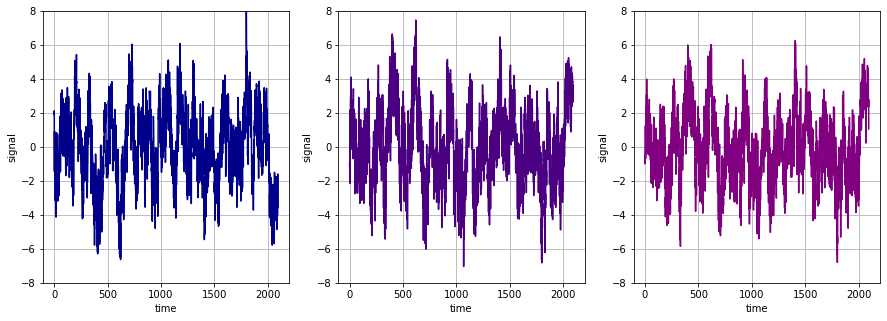

In [3]:
fig, axs = plt.subplots(1, 3, figsize=(15,5))
axs[0].plot(signal1, c='darkblue')
axs[1].plot(signal2, c='indigo')
axs[2].plot(signal3, c='purple')

for ax in axs:
    ax.set_xlabel('time')
    ax.set_ylabel('signal')
    ax.grid(True)
    ax.set_ylim(-8,8)
plt.show()

In [4]:
N = len(signal1)          ## number of points
Δt = 1                    ## timestep = how often signal is sampled
f_Nyq = 1/(2*Δt)          ## Nyquist frequency
f_Nyq

0.5

# Power spectrum

In [5]:
frequency, power_spectrum1 = get_power_spectrum(signal1, N, Δt)
frequency, power_spectrum2 = get_power_spectrum(signal2, N, Δt)
frequency, power_spectrum3 = get_power_spectrum(signal3, N, Δt)

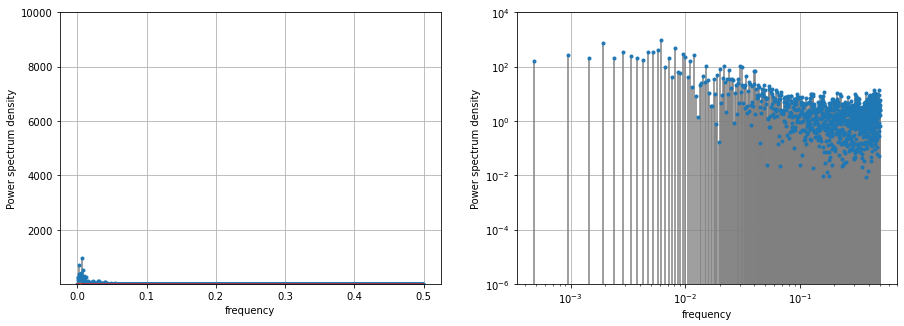

In [6]:
plot_power_spectrum(frequency, power_spectrum1)

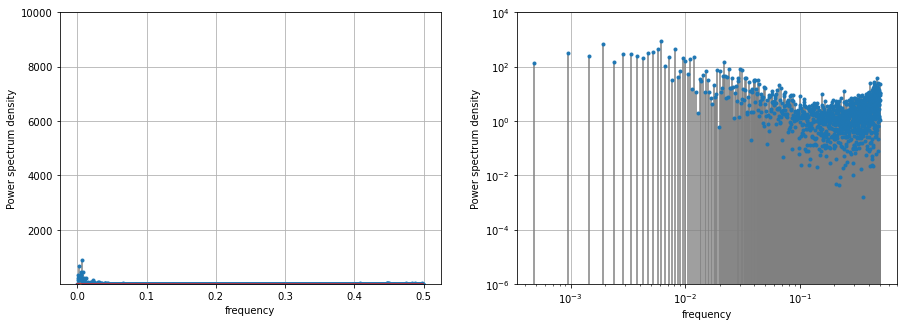

In [7]:
plot_power_spectrum(frequency, power_spectrum2)

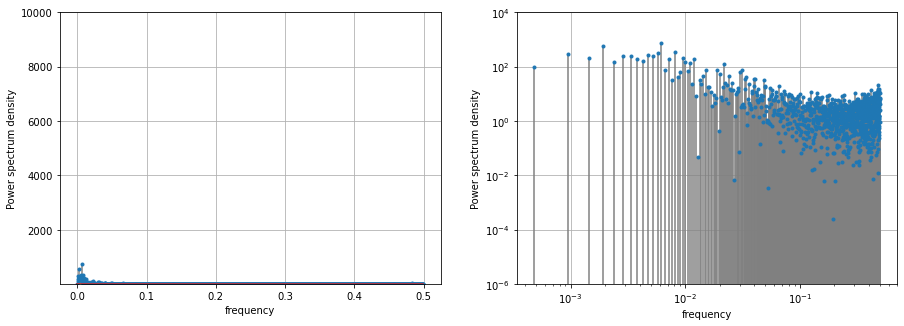

In [8]:
plot_power_spectrum(frequency, power_spectrum3)

# correlation coefficients

$$ r_n = \frac{\frac{1}{N-n} \sum_{i=m+1}^N y_{i-m} y_i}{ \frac{1}{N} \sum_{i=1}^N y_i^2}$$

$r_n$ - approximation of correlation coefficient

In [9]:
def dividing_data_into_subseries(data, k=2):
    data_k = []
    for i in range(len(data)-k):
        tmp = [ ]
        for j in range(k):
            tmp.append(data[j+i])
        tmp.append(data[k+i])
        data_k.append(tmp)
    
    return np.array(data_k).T

In [10]:
def get_autocorrelation_coeff(data, delta):
    data_k = dividing_data_into_subseries(data, k=delta)  
    denominator = (data**2).mean()
    nominator = (data_k[0]*data_k[-1]).mean()
    return nominator/denominator

In [11]:
def get_autocorrelation(p,data):
    autocorrelation_tab = []
    for delta in range(1,p+1):
        autocorrelation = get_autocorrelation_coeff(data, delta)
        autocorrelation_tab.append(autocorrelation)
    return autocorrelation_tab

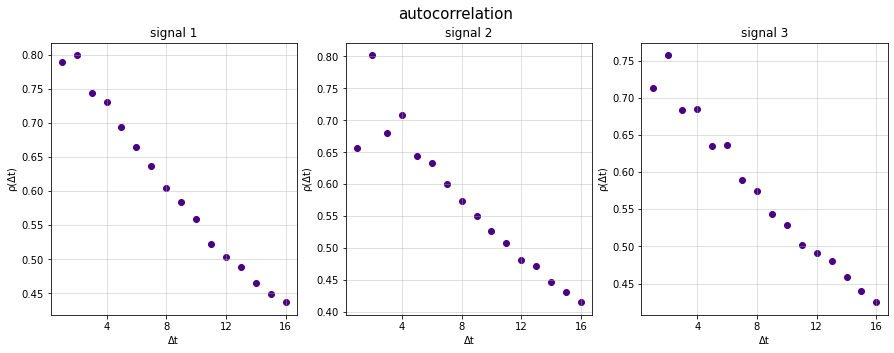

In [12]:
p=16
p_tab = list(range(1,p+1))
autocorrelation_tab1 = get_autocorrelation(p,signal1)
autocorrelation_tab2 = get_autocorrelation(p,signal2)
autocorrelation_tab3 = get_autocorrelation(p,signal3)

fig, axs = plt.subplots(nrows=1, ncols=3, figsize = (15,5))
for ax in axs:
    ax.set_xlabel('p')
    ax.grid(True, alpha = 0.5)
    ax.set_ylabel(u'\u03C1(\u0394t)')
    ax.set_xlabel(u'\u0394t')
    ax.set_xticks([0,4,8,12,16])
axs[0].set_title('signal 1')
axs[1].set_title('signal 2')
axs[2].set_title('signal 3')   
axs[0].scatter(p_tab, autocorrelation_tab1, color = 'indigo')
axs[1].scatter(p_tab, autocorrelation_tab2, color = 'indigo')
axs[2].scatter(p_tab, autocorrelation_tab3, color = 'indigo')
fig.suptitle('autocorrelation', fontsize=15);

#  partial correlations 

In [13]:
def get_partial_autocorrelation(p, data):
    
    autocorrelation_tab = get_autocorrelation(p,data)
    
    M = np.identity(p)*0.5
    for i in range(p):
        for j in range(i+1, p):
            M[i][j] = autocorrelation_tab[j-i-1]
    
    A = np.matrix(M.T + M)
    A_inv = np.linalg.inv(A) 
    
    psi_vec = np.array(np.dot(A_inv,autocorrelation_tab))[0]
    
    return psi_vec[-1]

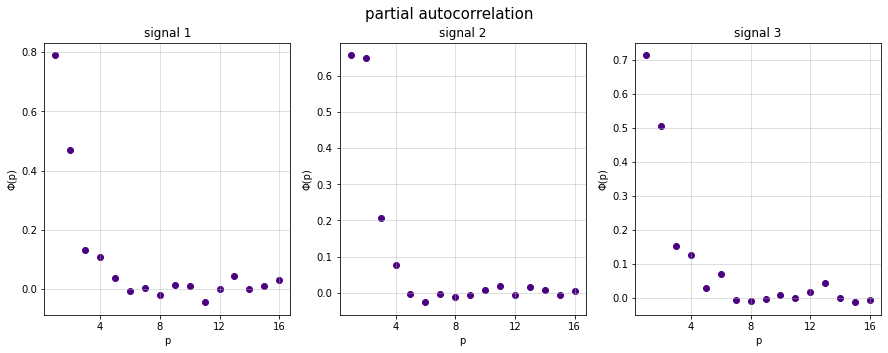

In [14]:
p=16
p_tab = list(range(1,p+1))

partial_corr_tab1 = []
partial_corr_tab2 = []
partial_corr_tab3 = []

for k in range(1,p+1):
    partial_corr_tab1.append(get_partial_autocorrelation(k,signal1))
    partial_corr_tab2.append(get_partial_autocorrelation(k,signal2))
    partial_corr_tab3.append(get_partial_autocorrelation(k,signal3))

fig, axs = plt.subplots(nrows=1, ncols=3, figsize = (15,5))
for ax in axs:
    ax.grid(True, alpha = 0.5)
    ax.set_ylabel(u'\u03A6(p)')
    ax.set_xlabel(u'p')
    ax.set_xticks([0,4,8,12,16])
axs[0].set_title('signal 1')
axs[1].set_title('signal 2')
axs[2].set_title('signal 3')  
axs[0].scatter(p_tab, partial_corr_tab1, color = 'indigo')
axs[1].scatter(p_tab, partial_corr_tab2, color = 'indigo')
axs[2].scatter(p_tab, partial_corr_tab3, color = 'indigo')
fig.suptitle('partial autocorrelation', fontsize=15);

# 

###  Akaike information criterion (AIC)

$$  \mathrm {AIC} = \ln\left( \frac{\sum_{i=1}^N \epsilon_i^2}{N}\right) + \frac{2p}{N} $$

where:
* $N = T-p$ - lenght of data series
* $p$ - number of parameters / $\beta_i$ ceofficients
* $\epsilon_i^2 = (y_i-\hat{y_i})^2$ - residual error


In [15]:
def dividing_data_into_subseries_II(data, k=2):
    X = []
    Y = []
    for i in range(len(data)-k):
        tmp = []
        for j in range(k):
            tmp.append(data[j+i])
        X.append(tmp)
        Y.append(data[k+i] )
    return np.array(X), np.array(Y)

In [16]:
AIC_tab1 = []
AIC_tab2 = []
AIC_tab3 = []

max_k = 17
k_tab = list(range(1,max_k))

for k in range(1,max_k):
    X,Y = dividing_data_into_subseries_II(signal1, k=k)
    N = len(X)
    reg = LinearRegression(fit_intercept = False).fit(X, Y)
    prediction = reg.predict(X)
    AIC_tab1.append(np.log( sum( (Y-prediction)**2)/N) + 2*k/N)
    
    X,Y = dividing_data_into_subseries_II(signal2, k=k)
    N = len(X)
    reg = LinearRegression(fit_intercept = False).fit(X, Y)
    prediction = reg.predict(X)
    AIC_tab2.append(np.log( sum( (Y-prediction)**2)/N) + 2*k/N)
    
    X,Y = dividing_data_into_subseries_II(signal3, k=k)
    N = len(X)
    reg = LinearRegression(fit_intercept = False).fit(X, Y)
    prediction = reg.predict(X)
    AIC_tab3.append(np.log( sum( (Y-prediction)**2)/N) + 2*k/N)

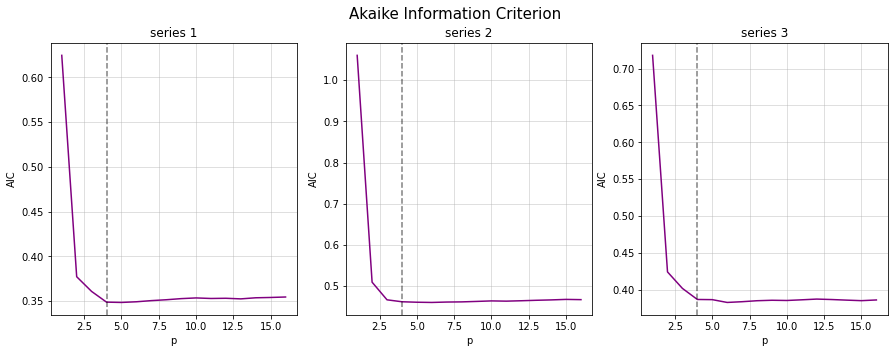

In [17]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize = (15,5))

for ax in axs:
    ax.set_xlabel('p')
    ax.set_ylabel('AIC')
    ax.grid(True, alpha = 0.5)
    
axs[0].set_title('series 1')
axs[1].set_title('series 2')
axs[2].set_title('series 3')
    
axs[0].plot(k_tab, AIC_tab1, color = 'purple')
axs[1].plot(k_tab, AIC_tab2, color = 'purple')
axs[2].plot(k_tab, AIC_tab3, color = 'purple')

axs[0].axvline(x=4, color = 'black', alpha = 0.5, ls = '--')
axs[1].axvline(x=4, color = 'black', alpha = 0.5, ls = '--')
axs[2].axvline(x=4, color = 'black', alpha = 0.5, ls = '--')
fig.suptitle('Akaike Information Criterion', fontsize=15);

best results are obtained for p=4

In [18]:
p=4

X,Y = dividing_data_into_subseries_II(signal1, p)
reg = LinearRegression(fit_intercept=False).fit(X, Y)
prediction = reg.predict(X)
N = len(X)

coeffs_1 = reg.coef_

alpha = np.sqrt(((prediction - Y)**2).mean())
AIC = np.log(((Y-prediction)**2).mean()) + 2*p/N
print("p = {:}, alpha = {:}\t AIC = {:}".format(p, alpha, AIC))
print("model parameters: intercept: {:} coefficients: {:}".format(reg.intercept_, reg.coef_))

p = 4, alpha = 1.1883257761456802	 AIC = 0.34891490316465645
model parameters: intercept: 0.0 coefficients: [0.10541787 0.09191858 0.37276518 0.34423727]


In [19]:
p=4

X,Y = dividing_data_into_subseries_II(signal2, p)
reg = LinearRegression(fit_intercept=False).fit(X, Y)
prediction = reg.predict(X)
N = len(X)

coeffs_2 = reg.coef_

alpha = np.sqrt(((prediction - Y)**2).mean())
AIC = np.log(((Y-prediction)**2).mean()) + 2*p/N
print("p = {:}, alpha = {:}\t AIC = {:}".format(p, alpha, AIC))
print("model parameters: intercept: {:} coefficients: {:}".format(reg.intercept_, reg.coef_))

p = 4, alpha = 1.257740738263945	 AIC = 0.46245818503516933
model parameters: intercept: 0.0 coefficients: [0.07683655 0.20104009 0.55772946 0.07818444]


In [20]:
p=4

X,Y = dividing_data_into_subseries_II(signal3, p)
reg = LinearRegression(fit_intercept=False).fit(X, Y)
prediction = reg.predict(X)
N = len(X)

coeffs_3 = reg.coef_

alpha = np.sqrt(((prediction - Y)**2).mean())
AIC = np.log(((Y-prediction)**2).mean()) + 2*p/N
print("p = {:}, alpha = {:}\t AIC = {:}".format(p, alpha, AIC))
print("model parameters: intercept: {:} coefficients: {:}".format(reg.intercept_, reg.coef_))

p = 4, alpha = 1.2112161806393307	 AIC = 0.3870740173626809
model parameters: intercept: 0.0 coefficients: [0.1267939  0.11850535 0.3944834  0.25579813]


# assess the noise level

$$P(0) = \frac{\alpha_0^2}{\left| 1- \sum_{n=1}^p \beta_n \right|^2}$$

In [21]:
P0_1 = power_spectrum1[1]
P0_2 = power_spectrum2[1]
P0_3 = power_spectrum3[1]

alpha1 = np.sqrt(P0_1 * abs(1-sum(coeffs_1))**2)
alpha2 = np.sqrt(P0_2 * abs(1-sum(coeffs_2))**2)
alpha3 = np.sqrt(P0_3 * abs(1-sum(coeffs_3))**2)

In [22]:
print("Noise level for series 1: alpha = {:.4f}".format(alpha1))
print("Noise level for series 2: alpha = {:.4f}".format(alpha2))
print("Noise level for series 3: alpha = {:.4f}".format(alpha3))

Noise level for series 1: alpha = 1.0871
Noise level for series 2: alpha = 0.9904
Noise level for series 3: alpha = 1.0414


# theoretical power spectrum of the model 

$$P(f) = \frac{\alpha_0^2}{\left| 1- \sum_{n=1}^p \beta_n \cdot e^{2\pi i n f}\right|^2}$$

In [23]:
def compare_pwd(frequency, power_spectrum_theoretical,  power_spectrum, y_min =1e-6, y_max = 1e4 ):
    fig, axs = plt.subplots(1, 2, figsize=(15,5), sharex = True)
    axs[0].stem(frequency, power_spectrum_theoretical, linefmt='lightgrey', markerfmt='.')
    axs[1].stem(frequency, power_spectrum, linefmt='lightgrey', markerfmt='.')
    axs[1].plot(frequency, power_spectrum_theoretical, c = 'indigo')
    axs[0].set_title("Theoretical Power Spectrum")
    axs[1].set_title("Power Spectrum obtained from data")
    axs[1].set_xlabel('frequency')
    for ax in axs:
        ax.set_ylabel('Power spectrum density') 
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_ylim(y_min, y_max)
        ax.grid(True)
    plt.tight_layout();

In [24]:
PI = np.pi
def PowerSpectrum(f, alpha0, coeffs):
    tmp = 0
    for n,beta in enumerate(coeffs):
        tmp+=  beta* np.exp( 2*np.pi * 1j * (n+1) * f )   
    return alpha0**2 / abs(1-tmp)**2

In [25]:
theoretical_1 = PowerSpectrum(frequency, alpha1, np.flip(coeffs_1))
theoretical_2 = PowerSpectrum(frequency, alpha2, np.flip(coeffs_2))
theoretical_3 = PowerSpectrum(frequency, alpha3, np.flip(coeffs_3))

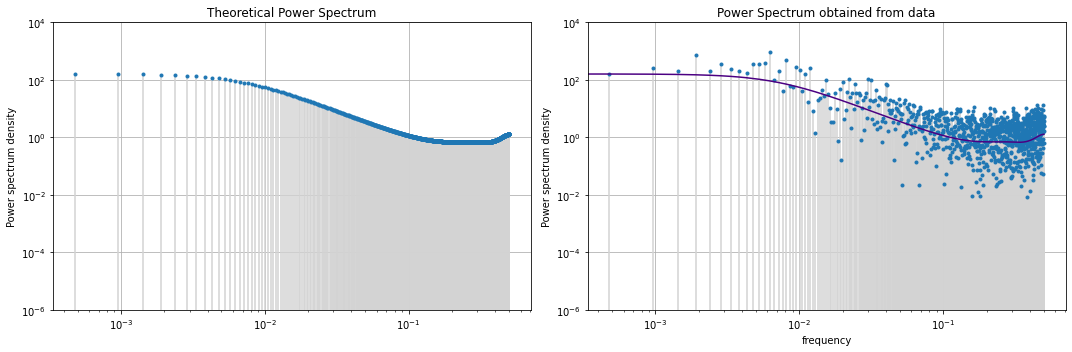

In [26]:
compare_pwd(frequency, theoretical_1,  power_spectrum1)

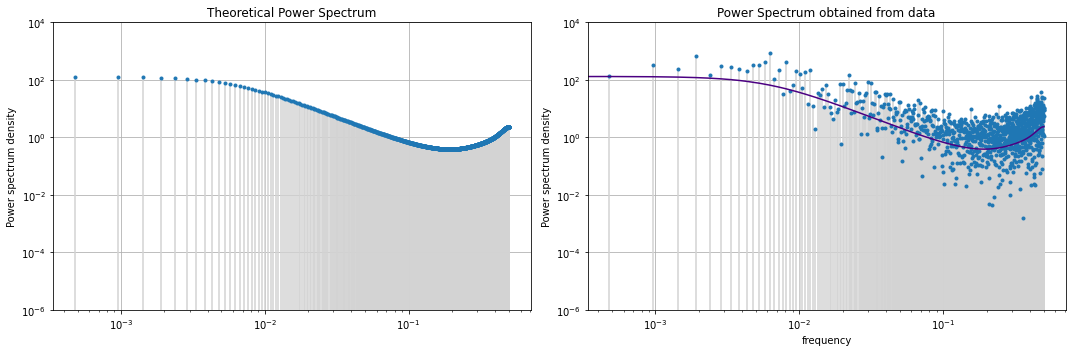

In [27]:
compare_pwd(frequency, theoretical_2,  power_spectrum2)

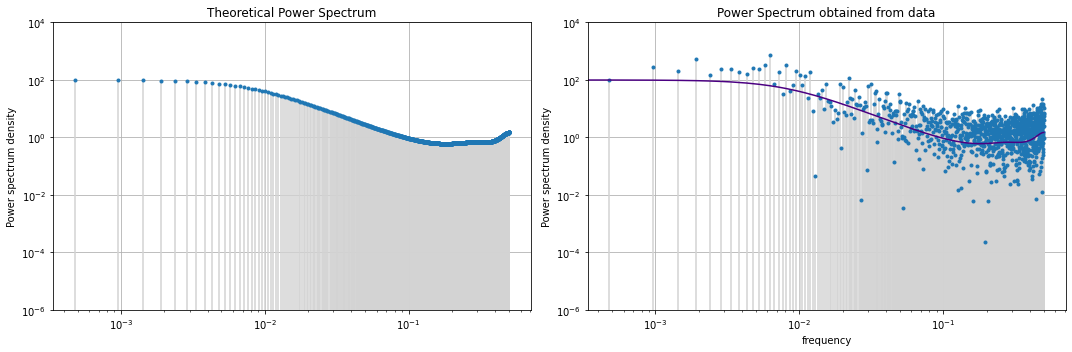

In [28]:
compare_pwd(frequency, theoretical_3,  power_spectrum3)